# Safe and Sound Protocol

**Abstract:** This notebook modulates the frequencies of a given audio file in a way that is similar to the Safe and Sound Protocol (SPP).

**Background:** The [Safe and Sound Protocol](https://integratedlistening.com/ssp-safe-sound-protocol/) is a therapeutic treatment protocol based on [Polyvagal Theory](https://en.wikipedia.org/wiki/Polyvagal_theory) that has application in autism treatment and trauma therapy. Its basic idea is to exercise the middle-ear muscles to increase their capacity of filtering out low frequency sounds and tune into higher frequencies - which in turn can support reaching or maintining a physiological state of safety.

**Scope:** _This is a purely private code project that allows me to look into the science of SPP more closely. Note that beyond this scope, SPP is based on patented ideas and its commercial availability is restricted to licenced professionals._


## Imports

In [0]:
import IPython
import collections
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn
import scipy.io.wavfile
import scipy.signal

## Frequency filters

The basic idea (as I understand it) is to take a piece of (vocal) music and filter its frequencies to a range to which the middle-ear muscles are tuned in a state of physiological state of safety. To exercise the middle-ear muscles further, the range of these frequencies is varied over time. That is, the frequency range varies during the track itself and the variations are further increased from day to day during the treatment protocol.

Example of minimum and maximum frequencies during treatment days one and two:

[![Example of frequency modulation](https://patentimages.storage.googleapis.com/bf/7f/33/36f5e0b2a961c4/US10029068-20180724-D00005.png =480x)](https://patents.google.com/patent/US10029068B2/)

The following code defines some helper functions to build frequency filters similar to the above example.

Text(0.5, 1.0, 'generate_filter_cosines()')

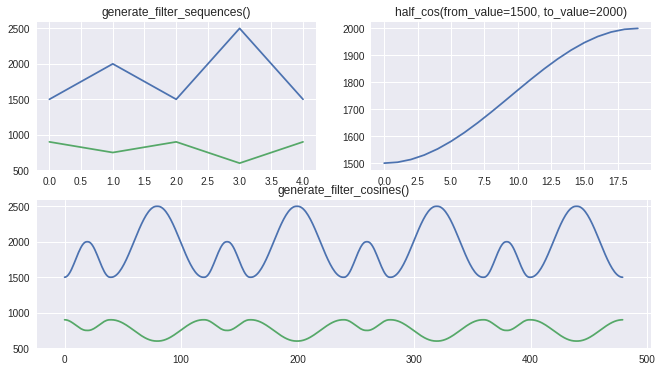

In [22]:
# Helper function that takes a list of peaks and generates two sequences that 
# will serve to filter out frequencies above the highs and below the lows:
# The upper sequence oscillates between 'high_base' and the values in 
# 'high_peaks'; The lower sequence complements the shape of the upper sequence 
# by oscillating between 'low_base' and values that mirror the 'high_peaks'
# (down to 'low_peak').
def generate_filter_sequences(high_peaks, high_base, low_base, low_peak):
    assert(low_base >= low_peak)
    assert(high_base <= min(high_peaks))
    seq_high = [high_base]
    seq_low  = [low_base]
    largest_high_peak = max(high_peaks)
    high_diff = largest_high_peak - high_base
    low_diff = low_base - low_peak
    for peak in high_peaks:
        seq_high += [peak, high_base]
        seq_low  += [low_base-low_diff*(peak-high_base)/high_diff, low_base]
    return [seq_high, seq_low]

# example of generated sequences
seq_high, seq_low = generate_filter_sequences(high_peaks=[2000, 2500], high_base=1500, low_peak=600, low_base=900)
plt.figure(figsize=(11,6))
plt.subplot(2, 2, 1)
plt.plot(np.array([seq_high, seq_low]).T)
plt.title('generate_filter_sequences()')


# Returns an array with a half-cosine movinh from 'from_value' to 'to_value' in 
# 'n_steps' steps (default: abs(from_value-to_value)/12.5).
def half_cos(from_value, to_value, n_steps=None):
    sign = 1
    if from_value > to_value:
        from_value, to_value, sign = to_value, from_value, -1
    height = to_value - from_value
    assert (height >= 0)
    if not n_steps:
        n_steps = int(height/25)
    result = (height * (-sign * np.cos(np.linspace(0, np.pi, num=n_steps)) / 2 + .5) + from_value)
    assert(len(result) == n_steps)
    return result

# illustration of result
plt.subplot(2, 2, 2)
plt.plot(half_cos(from_value=1500, to_value=2000))
plt.title('half_cos(from_value=1500, to_value=2000)')


# Takes list of scalars and creates a sequence that connects these points 
# through half-cosinses. 'length' is either a scalar that defines the length of
# the whole output sequence or a list of values that specify the lengths of the
# individual half-cosine steps.
def generate_filter_cosines(points_to_connect, length):
    # Is N an integer or a list of step sizes?
    half_cos_lenghts = None
    if isinstance(length, collections.Sequence):
        half_cos_lenghts = length
        length = sum(step_sizes)
    # construc sequence of half-cosines
    num_points = len(points_to_connect)
    result_curve = np.empty(0)
    result_lengths = []
    i = 0
    while len(result_curve) < length:
        step_size = half_cos_lenghts[i%num_points] if half_cos_lenghts is not None else None
        step = half_cos(from_value=points_to_connect[i%num_points], to_value=points_to_connect[(i+1)%num_points], n_steps=step_size)
        result_curve = np.hstack([result_curve, step])
        result_lengths.append(len(step))
        i += 1
    return result_curve, result_lengths

# illustration of result
plt.subplot(2, 1, 2)
filter_high, step_sizes = generate_filter_cosines(points_to_connect=seq_high, length=480)
filter_low,  step_sizes = generate_filter_cosines(points_to_connect=seq_low,  length=step_sizes)
assert(filter_high.shape == filter_low.shape)
plt.plot(filter_high)
plt.plot(filter_low)
plt.title('generate_filter_cosines()')

## Input WAV

### List available files

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)
files = !ls -1 '/content/gdrive/My Drive/Datasets/SafeAndSound/'
print('\n'.join(['%d : %s' % (i, file) for i, file in enumerate(files)]))

### Select input WAV

In [31]:
#@title  { run: "auto", vertical-output: true }
file_index = 1 #@param {type:"integer"}
input_filename = './gdrive/My Drive/Datasets/SafeAndSound/' + files[file_index]
print(input_filename)


./gdrive/My Drive/Datasets/SafeAndSound/happy.wav


### Read selected file

In [32]:
# read selected input file
fs, data = scipy.io.wavfile.read(input_filename, mmap=True)
data = data[:,0] # only left channel for now
input_seconds = data.shape[0] // fs
output_filename = os.path.splitext(input_filename)[0] + '_modulated.wav'
print('Input:  %s\nOutput: %s\n-> %d frames (%ds) at a sample rate of %dHz' % (input_filename, output_filename, data.shape[0], input_seconds, fs))

Input:  ./gdrive/My Drive/Datasets/SafeAndSound/happy.wav
Output: ./gdrive/My Drive/Datasets/SafeAndSound/happy_modulated.wav
-> 10614575 frames (240s) at a sample rate of 44100Hz


## Calculate filter

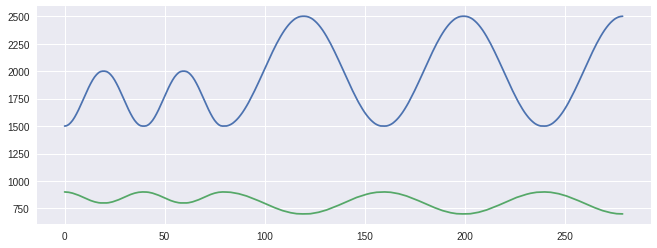

In [33]:
# Generate filter
high_peaks = [2000, 2000, 2500, 2500, 2500, 3000, 2500, 2000, 2500, 3000, 3000, 2500]
seq_high, seq_low = generate_filter_sequences(high_peaks=high_peaks, high_base=1500, low_base=900, low_peak=600)
filter_high, step_sizes = generate_filter_cosines(points_to_connect=seq_high, length=input_seconds+2)
filter_low,  _          = generate_filter_cosines(points_to_connect=seq_low,  length=step_sizes)
filter = np.array([filter_high, filter_low], dtype=np.int).T

# plot filter
plt.figure(figsize=(11,4))
plt.plot(filter)

## Apply filter and transform back to WAV

To apply the filters, a Short-time Fourier Transform (STFT) is calculated for the audio signal with (half-overlapping) windows of lengths 1s. After setting the signal's power to zero outside of the desired frequency range, the signal is transformed back into the time domain.

In [34]:
# STFTs
_, _, Zxx = scipy.signal.stft(x=data, fs=fs, window='hanning', nperseg=fs)
Zxx = Zxx.T
num_stfts = Zxx.shape[0]
loudness = np.abs(Zxx)#np.power(np.abs(Zxx), .67)

# apply filter (factor 2 because of overlapping STFT windows)
assert(filter.shape[0] >= num_stfts//2)
max_loudness_factor = 0
for t in range(num_stfts):
    max_freq = filter[t//2,0]
    min_freq = filter[t//2,1]
    Zxx[t,max_freq:] = 0
    Zxx[t,:min_freq] = 0
    loudness_remaining = np.sum(loudness[t,min_freq:max_freq])
    if loudness_remaining > 0:
        loudness_factor = np.sum(loudness[t,:]) / np.sum(loudness[t,min_freq:max_freq])
        max_loudness_factor = max(max_loudness_factor, loudness_factor)
        Zxx[t] *= loudness_factor
Zxx /= max_loudness_factor
    
# back to wave
_, filtered_data = scipy.signal.istft(Zxx=Zxx.T, fs=fs, window='hanning', nperseg=fs)
filtered_data = np.array(filtered_data, dtype=np.int16)

# write wave file
scipy.io.wavfile.write(output_filename, fs, filtered_data)
print('result written to %s' % output_filename)

result written to ./gdrive/My Drive/Datasets/SafeAndSound/happy_modulated.wav
